# Task 3: SGPU, DDP, FSDP

In [ ]:
from dataclasses import dataclass
import copy
import torch
import math
import torch.nn as nn
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F
# from torch.nn.modules.normalization import LayerNorm
from torch.nn.modules import ModuleList




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Model Architecture

In [ ]:
class LayerNorm(nn.Module):

    def __init__(self, hidden_size, epsilon=1e-12):
      """
      Initialize LayerNorm module.
      """
      super().__init__()

      # Learnable weight parameter for scaling.
      self.weight = nn.Parameter(torch.ones(hidden_size))

      # Learnable bias parameter for shifting.
      self.bias = nn.Parameter(torch.zeros(hidden_size))

      # Small value to avoid division by zero in normalization.
      self.epsilon = epsilon

    def forward(self, x):

      # Compute mean and variance along the last dimension.
      u = x.mean(-1, keepdim=True)
      s = (x - u).pow(2).mean(-1, keepdim=True)

      # Normalize the input tensor.
      x = (x - u) / torch.sqrt(s + self.epsilon)

      # Scale and shift using learnable parameters.
      return self.weight * x + self.bias

In [ ]:
class Conv1D(nn.Module):
    def __init__(self, nx, nf):
        '''
        nx: Number of input features.
        nf: Number of filters (output channels).
        '''
        super().__init__()
        self.nf = nf
        #intialising an empty matrix as weights for size of (nx)X(nf)
        w = torch.empty(nx, nf)
        #initialising these weights as normal distribution
        nn.init.normal_(w, std=0.02)
        #calculating the weights and biases by encoding them using nn.Parameter
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        '''x:The input tensor'''
        #this size output is summation of x second dimension and the nf dimension
        size_out = x.size()[:-1] + (self.nf,)
        # dot multiplying Q,K(transpose) and V
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)#x.view helps in taking the transpose out
        x = x.view(*size_out)
        return x

In [ ]:
d_model = 768
conv1d  = Conv1D(d_model, d_model*3)
x = torch.rand(1,4,d_model) # A random input tensor for testing out our model
x = conv1d(x)
x.shape

torch.Size([1, 4, 2304])

In [ ]:
query, key, value = x.split(d_model, dim=-1)# here we can split our output attention into query, key and value

query.shape, key.shape, value.shape

(torch.Size([1, 4, 768]), torch.Size([1, 4, 768]), torch.Size([1, 4, 768]))

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dropout, d_model=768, nx=768*4):
        super().__init__()
        self.c_fc    = Conv1D(d_model, nx)
        self.c_proj  = Conv1D(nx, d_model)
        self.act     = F.gelu
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=768, n_head=12, n_ctx=1024, d_head=64, bias=True, scale=False):
        '''Constructor funtion
        Params:
        d_model:The dimension that needs to be feed into our model
        n_head:The number of heads for attention
        n_ctx:a parameters for buffer registry for bias
        d_head:the dimension head output
        bias:A bool for including or not including bias
        scale: Whether to scale the attention scores by the square root of the dimension of the queries(use sqrt(dk) or not) "
        '''
        super().__init__()
        self.n_head  = n_head
        self.d_model = d_model
        self.c_attn  = Conv1D(d_model, d_model*3)
        self.scale   = scale
        self.softmax = nn.Softmax(dim=-1)
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.dropout = nn.Dropout(0.1)
        self.c_proj  = Conv1D(d_model, d_model)

    def split_heads(self, x):
        """
        spliting inyo given number of heads and then returning
        return shape [`batch`, `head`, `sequence`, `features`]
        """
        new_shape = x.size()[:-1] + (self.n_head, x.size(-1)//self.n_head)
        x = x.view(*new_shape)
        return x.permute(0, 2, 1, 3)

    def _attn(self, q, k, v, attn_mask=None):
        """The main attention function
        That claculates the attention using our dot product formula"""
        scores  = torch.matmul(q, k.transpose(-2, -1))# dot multiplication between q and k transpose
        if self.scale: scores = scores/math.sqrt(v.size(-1))# scaling it by dividing by sqrt(dk)
        nd, ns  = scores.size(-2), scores.size(-1)
        if attn_mask is not None: scores = scores + attn_mask# adding scores with attention mask values
        scores  = self.softmax(scores)# adding softmax values
        scores  = self.dropout(scores) #dropout of 0.1 as mentioned
        outputs = torch.matmul(scores, v) # now the final matrix multiplication between score and V
        return outputs

    def merge_heads(self, x):
        # merging the attention heads into one
        x = x.permute(0, 2, 1, 3).contiguous()
        new_shape = x.size()[:-2] + (x.size(-2)*x.size(-1),)
        return x.view(*new_shape)

    def forward(self, x):
        '''The feed forward function that calculates the attention, split the heads, make attention, merge heads and project out the output '''
        x        = self.c_attn(x) #new `x` shape - `[1,3,2304]`
        q, k, v  = x.split(self.d_model, dim=2)
        q, k, v  = self.split_heads(q), self.split_heads(k), self.split_heads(v)
        out      = self._attn(q, k, v)
        out      = self.merge_heads(out)
        out      = self.c_proj(out)
        return out

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=768, n_head=12, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attn        = MultiHeadAttention(d_model=768, n_head=12, d_head=64, n_ctx=1024, bias=True, scale=False)
        self.feedforward = FeedForward(dropout=0.1, d_model=768, nx=768*4)
        self.ln_1        = LayerNorm(d_model)
        self.ln_2        = LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.feedforward(self.ln_2(x))
        return x

In [ ]:
def _get_clones(module, n):
    '''Here we can make certain copies of transformers'''
    return ModuleList([copy.deepcopy(module) for i in range(n)])

In [ ]:
class GPT2(nn.Module):
    def __init__(self, nlayers=12, n_ctx=1024, d_model=768, vcb_sz=50257):
        '''nlayer:The number of times the tarnsformer needs to get cloned
        n_ctx:The highest length that can be these to get teh string positional embeddings
        d_model:The dimenionalities for model
        vcb_sz:The vocablury size which can be later altered while training'''
        super(GPT2, self).__init__()
        self.nlayers = nlayers
        block        = TransformerBlock(d_model=768, n_head=12, dropout=0.1)
        self.h       = _get_clones(block, 12)
        self.wte     = nn.Embedding(vcb_sz, d_model)
        self.wpe     = nn.Embedding(n_ctx, d_model)
        self.drop    = nn.Dropout(0.1)
        self.ln_f    = LayerNorm(d_model)
        self.out     = nn.Linear(d_model, vcb_sz, bias=False)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_weights()

    def init_weights(self):
        '''Initialization of weights'''
        self.out.weight = self.wte.weight
        self.apply(self._init_weights)

    def _init_weights(self, module):
        '''If the Linear, Embedding and Conv1D then nomrally initializing with mean and S.D'''
        if isinstance(module, (nn.Linear, nn.Embedding, Conv1D)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, (nn.Linear, Conv1D)) and module.bias is not None:
                '''Data Bias zero'''
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, src, labels=None, pos_ids=None):
        '''Adding the positional embedding, dropping, then adding inputs, logits and outputs which are being used for loss function and then adding outputs and loss'''
        if pos_ids is None:
            pos_ids = torch.arange(0, src.size(-1)).unsqueeze(0)
        pos_ids = pos_ids.to(src.device)  # Ensure pos_ids is on the same device as src
        inp = self.drop((self.wte(src) + self.wpe(pos_ids)))
        for i in range(self.nlayers): inp = self.h[i](inp)
        inp     = self.ln_f(inp)
        logits  = self.out(inp)
        outputs = (logits,) + (inp,)

        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = self.loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs
            return loss.mean()
        return logits

# Single GPU Training Loop
This is a code for training our GPT-2 on a single GPU
For these purpose I would be using tinyshakespeare/input.txt

In [ ]:
class TrainerConfig:
    '''Class for setting the Training for training configurations'''
    # optimization parameters
    max_epochs = 10
    batch_size = 8
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1  # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6  # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9  # (at what we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0  # for DataLoader

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

In [ ]:
class Trainer:
    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info(f"saving {self.config.ckpt_path}")
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config#getting the model and training configurations
        raw_model = model.module if hasattr(self.model, "module") else model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.learning_rate)

        def run_epoch(split):
            is_train = split == "train"
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(
                data,
                shuffle=True,
                pin_memory=True,
                batch_size=config.batch_size,
                num_workers=config.num_workers,
            )

            losses = []
            pbar = (
                tqdm(enumerate(loader), total=len(loader))
                if is_train
                else enumerate(loader)
            )
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    loss = model(x, y)  # The forward method returns the mean of the loss directly
                    logits = model(x)
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward(retain_graph=True)
                    torch.nn.utils.clip_grad_norm_(
                        model.parameters(), config.grad_norm_clip
                    )
                    self.optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (
                            y >= 0
                        ).sum()  # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(
                                max(1, config.warmup_tokens)
                            )
                        else:
                            # cosine learning rate decay
                            progress = float(
                                self.tokens - config.warmup_tokens
                            ) / float(
                                max(1, config.final_tokens - config.warmup_tokens)
                            )
                            lr_mult = max(
                                0.1, 0.5 * (1.0 + math.cos(math.pi * progress))
                            )
                        lr = config.learning_rate * lr_mult
                        for param_group in self.optimizer.param_groups:
                            param_group["lr"] = lr
                    else:
                        lr = config.learning_rate

                    # repeat progress
                    pbar.set_description(
                        f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}, lr {lr:e}"
                    )

            if not is_train:
                test_loss = float(np.mean(losses))
                logger.info(f"test loss: {test_loss}")
                return test_loss

        best_loss = float("inf")
        self.tokens = 0  # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            run_epoch("train")
            if self.test_dataset is not None:
                test_loss = run_epoch("test")

            # supports early stopping based on the test loss, or just save always is no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss if self.test_dataset is not None else float("inf")
                self.save_checkpoint()

In [ ]:
from torch.utils.data import Dataset


In [ ]:
class CharDataset(Dataset):

    def __init__(self, data, block_size):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print(f"data has {data_size:d} characters, {vocab_size:d} unique.")

        self.stoi = { ch: i for i, ch in enumerate(chars) }
        self.itos = { i: ch for i, ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx+self.block_size+1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [ ]:
block_size=25

Reference link for dataset -- https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-12-17 15:57:50--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.8’

input.txt.8         100%[===================>]   1.06M  6.04MB/s    in 0.2s    

2023-12-17 15:57:51 (6.04 MB/s) - ‘input.txt.8’ saved [1115394/1115394]



In [ ]:
text = open('input.txt', 'r').read()
train_dataset = CharDataset(text, block_size = 25) # 25 is for context storing

data has 1115394 characters, 65 unique.


In [ ]:

trainable_model = GPT2()
trainable_model=trainable_model.to(device)

In [ ]:
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm



In [ ]:
tconf = TrainerConfig(
    max_epochs=1,
    batch_size=16,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=512,
    final_tokens=2*len(train_dataset)*block_size,
    num_workers=4,
)
trainer = Trainer(trainable_model, train_dataset, None, tconf)
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/69711 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

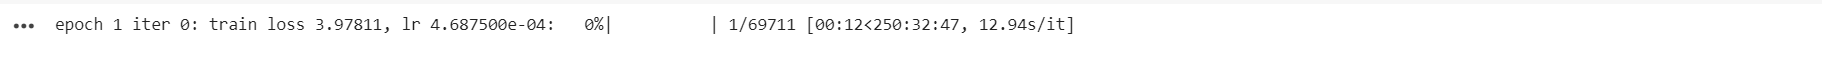

It keeps going.. takes 3hrs

# DDP

In [ ]:
import os
import torch.distributed as dist

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

In [ ]:
def cleanup():
    dist.destroy_process_group()

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

import logging
logging.basicConfig(level = logging.INFO)
logger = logging.getLogger()

In [ ]:
class Trainer_DDP:
    def __init__(self, model, train_dataset, test_dataset, config,rank,world_size):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config
        self.rank=rank
        self.world_size=world_size

        # take over whatever gpus are on the system
        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info(f"saving {self.config.ckpt_path}")
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config#getting the model and training configurations
        setup(self.rank, self.world_size)
        model = model().to(self.rank)#moving the model to device
        model = DDP(model, device_ids=[self.rank], output_device=self.rank, find_unused_parameters=True)#wrapping the model with DDP
        raw_model = model.module if hasattr(self.model, "module") else model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.learning_rate)

        def run_epoch(self,split):
            print("running")
            is_train = split == "train"
            model.train(is_train)
            train_sampler=DistributedSampler(train_dataset, num_replicas=world_size, rank=self.rank, shuffle=False, drop_last=False)#making a distributed sampler for data parallel
            data = self.train_dataset if is_train else self.test_dataset

            self.loader = DataLoader(
                data,
                shuffle=True,
                pin_memory=True,
                batch_size=config.batch_size,
                num_workers=config.num_workers,
                sampler=train_sampler # adding this as sampler fr distributed data
            )

            losses = []
            pbar = (
                tqdm(enumerate(self.loader), total=len(self.loader))
                if is_train
                else enumerate(self.loader)
            )
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    loss = model(x, y)  # The forward method returns the mean of the loss directly
                    logits = model(x)
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward(retain_graph=True)
                    torch.nn.utils.clip_grad_norm_(
                        model.parameters(), config.grad_norm_clip
                    )
                    self.optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (
                            y >= 0
                        ).sum()  # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(
                                max(1, config.warmup_tokens)
                            )
                        else:
                            # cosine learning rate decay
                            progress = float(
                                self.tokens - config.warmup_tokens
                            ) / float(
                                max(1, config.final_tokens - config.warmup_tokens)
                            )
                            lr_mult = max(
                                0.1, 0.5 * (1.0 + math.cos(math.pi * progress))
                            )
                        lr = config.learning_rate * lr_mult
                        for param_group in self.optimizer.param_groups:
                            param_group["lr"] = lr
                    else:
                        lr = config.learning_rate

                    # repeat progress
                    pbar.set_description(
                        f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}, lr {lr:e}"
                    )
                    cleanup()#cleaning up all the the done files on all GPUs

            if not is_train:
                test_loss = float(np.mean(losses))
                logger.info(f"test loss: {test_loss}")
                return test_loss

        best_loss = float("inf")
        self.tokens = 0  # counter used for learning rate decay
        for epoch in range(config.max_epochs):
            # if we are using DistributedSampler, we have to tell it which epoch this is
            self.loader.sampler.set_epoch(epoch)
            run_epoch("train")
            if self.test_dataset is not None:
                test_loss = run_epoch("test")

            # supports early stopping based on the test loss, or just save always is no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss if self.test_dataset is not None else float("inf")
                self.save_checkpoint()

In [ ]:
def init_process(rank,model,train_dataset,test_dataset,config, world_size):
    torch.cuda.set_device(rank)
    setup(rank, world_size)

    # create model, datasets, etc.
    trainer = Trainer_DDP(model, train_dataset, test_dataset, config, rank, world_size)
    trainer.train()

In [ ]:
trainable_model = GPT2()

In [ ]:
tconf = TrainerConfig(
    max_epochs=1,
    batch_size=8,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=512,
    final_tokens=2*len(train_dataset)*block_size,
    num_workers=4,
)

In [ ]:
import torch.multiprocessing as mp

# Check the number of available GPUs
num_gpus = torch.cuda.device_count()

# Ensure that there are at least 2 GPUs available
if num_gpus < 2:
    print("Error: This script requires at least 2 GPUs for multiprocessing.")
    exit()

# Set the world size based on the number of GPUs
world_size = num_gpus

mp.spawn(
    init_process,
    args=(trainable_model, train_dataset, None, tconf, world_size),
    nprocs=world_size,
    join=True
)


Error: This script requires at least 2 GPUs for multiprocessing.


# FSDP
FSDP, or Fully Sharded Data Parallel, optimizes model training by combining model sharding and data parallelism. Unlike DDP, it allows efficient computation by wrapping model layers in a nested way, reducing the need to gather parameters across devices during forward and backward passes. This results in enhanced model efficiency and optimized training.


In [ ]:
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
from torch.distributed.fsdp.wrap import (
    size_based_auto_wrap_policy,
    enable_wrap,
    wrap,
)


In [ ]:
class Trainer_FSDP:
    def __init__(self, model, train_dataset, test_dataset, config, rank, world_size):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config
        self.rank = rank
        self.world_size = world_size

        # Use available GPUs if present
        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info(f"saving {self.config.ckpt_path}")
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def setup_ddp(self):
        # Distributed Data Parallel setup
        setup(self.rank, self.world_size)
        self.model = self.model().to(self.rank)
        self.model = DDP(self.model, device_ids=[self.rank], output_device=self.rank, find_unused_parameters=True)

    def initialize_optimizer(self):
        # Initialize optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.learning_rate)

    def run_epoch(self, split):
        print("running")
        is_train = split == "train"
        model.train(is_train)
        train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=self.rank, shuffle=False, drop_last=False)
        data = self.train_dataset if is_train else self.test_dataset

        self.loader = DataLoader(
            data,
            shuffle=True,
            pin_memory=True,
            batch_size=self.config.batch_size,
            num_workers=self.config.num_workers,
            sampler=train_sampler
        )
        # Set up auto wrap policy for our model
        my_auto_wrap_policy = functools.partial(
            size_based_auto_wrap_policy, min_num_params=100
        )
        torch.cuda.set_device(rank)

        # Starting and ending for our cuda event denoting when to allocate and free the memory
        init_start_event = torch.cuda.Event(enable_timing=True)
        init_end_event = torch.cuda.Event(enable_timing=True)

        # Setting up FSDP on our model
        model = FSDP(self.model)

        losses = []
        pbar = tqdm(enumerate(self.loader), total=len(self.loader)) if is_train else enumerate(self.loader)
        for it, (x, y) in pbar:
            # Place data on the correct device
            x = x.to(self.device)
            y = y.to(self.device)

            # Forward the model
            with torch.set_grad_enabled(is_train):
                loss = model(x, y)
                logits = model(x)
                losses.append(loss.item())

            if is_train:
                # Backprop and update the parameters
                model.zero_grad()
                loss.backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm_(model.parameters(), self.config.grad_norm_clip)
                self.optimizer.step()

                # Decay the learning rate based on our progress
                if self.config.lr_decay:
                    self.tokens += (y >= 0).sum()
                    if self.tokens < self.config.warmup_tokens:
                        lr_mult = float(self.tokens) / float(max(1, self.config.warmup_tokens))
                    else:
                        progress = float(self.tokens - self.config.warmup_tokens) / float(
                            max(1, self.config.final_tokens - self.config.warmup_tokens)
                        )
                        lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                    lr = self.config.learning_rate * lr_mult
                    for param_group in self.optimizer.param_groups:
                        param_group["lr"] = lr
                else:
                    lr = self.config.learning_rate

                pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}, lr {lr:e}")
                cleanup()

        if not is_train:
            test_loss = float(np.mean(losses))
            logger.info(f"test loss: {test_loss}")
            return test_loss

    def train(self):
        self.setup_ddp()
        self.initialize_optimizer()
        best_loss = float("inf")
        self.tokens = 0  # Counter used for learning rate decay
        for epoch in range(self.config.max_epochs):
            # If we are using DistributedSampler, we have to tell it which epoch this is
            self.loader.sampler.set_epoch(epoch)
            self.run_epoch("train")
            if self.test_dataset is not None:
                test_loss = self.run_epoch("test")

            # Supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss if self.test_dataset is not None else float("inf")
                self.save_checkpoint()


In [ ]:
trainable_model = GPT2()#initialsing our model for training

In [ ]:
tconf = TrainerConfig(
    max_epochs=1,
    batch_size=8,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=512,
    final_tokens=2*len(train_dataset)*block_size,
    num_workers=4,
)

In [ ]:
import torch.multiprocessing as mp

# Check the number of available GPUs
num_gpus = torch.cuda.device_count()

# Ensure that there are at least 2 GPUs available
if num_gpus < 2:
    print("Error: This script requires at least 2 GPUs for parallel training.")
    exit()

# Set the world size based on the number of GPUs
world_size = num_gpus

# Spawn processes for parallel training
mp.spawn(
    init_process,
    args=(trainable_model, train_dataset, None, tconf, world_size),
    nprocs=world_size,
    join=True
)


Error: This script requires at least 2 GPUs for parallel training.
